In [1]:
import numpy as np
import pandas as pd
import numpy.random as rng
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel('iso-dataset.xlsx')
df = df[df['charge_heater'] >= 0]

(4975, 28)

# Random Experimentation

In [195]:
ron = np.array(df['ron'])

best_rons = []
for r in range(100):
    random_ix = rng.permutation(ron.shape[0])
    obs_ron = ron[random_ix]
    best_ron = np.maximum.accumulate(obs_ron)
    best_rons.append(best_ron)
avg_best_ron_random = np.mean(best_rons, axis=0)

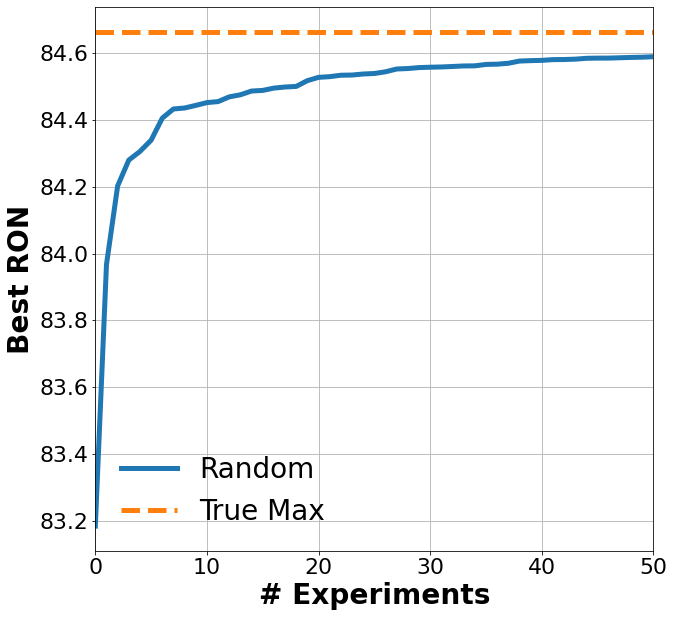

In [196]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(np.arange(ron.shape[0]), avg_best_ron_random, linewidth=5, label='Random')
ax.plot(np.arange(ron.shape[0]), np.ones_like(ron) * np.max(ron), linewidth=5, linestyle='--', label='True Max')
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
ax.set_xlabel('# Experiments', fontsize=28, fontweight='bold')
ax.set_ylabel('Best RON', fontsize=28, fontweight='bold')
ax.set_xlim([0, 50])
ax.grid(True)
ax.legend(fontsize=28, frameon=False)

# Bayesian Optimization

In [74]:
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from scipy.stats import norm

In [75]:
X = np.array(df[['r1temp', 'r2temp', 'r1pressure', 'r2pressure']])
y = np.array(df[['ron']])

In [186]:
# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

# probability of improvement acquisition function
def acquisition(X, Xsamples, avail_indecies, model):
    
	# calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    #print(best)
	# calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)

    mu = mu[:, 0]
	# calculate the probability of improvement
    probs = norm.cdf((mu - best) / (std+1E-9))
    
    # don't pick anything that has already been used
    
    probs[~avail_indecies] = 0
    
    return probs

# optimize the acquisition function
def opt_acquisition(Xsamples, avail_indecies, X, y, model):
	
	# calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, avail_indecies, model)
    
    # locate the index of the largest scores
    ix = rng.permutation(scores.shape[0])
    best_ix = max(ix, key=lambda i: scores[i])
    
    return best_ix


In [200]:
N_SAMPLES_TO_DRAW = 200
REPS = 50

best_rons = []
indecies = set(range(X.shape[0]))

for r in range(REPS):
    # initialize the model
    ix = rng.choice(X.shape[0], 1)
    Xtrain = X[ix,:]
    ytrain = y[ix,:]
    model = GaussianProcessRegressor()
    model.fit(Xtrain, ytrain)

    best_ron = []
    # perform the optimization process
    
    avail_indecies = np.ones(X.shape[0]).astype(bool)
    avail_indecies[ix] = False 
   
    for i in range(100):

        # select the next point to sample
        #ix = rng.permutation(X.shape[0])[:N_SAMPLES_TO_DRAW]
        #Xsamples = X[ix,:]
        ix = opt_acquisition(X, avail_indecies, Xtrain, ytrain, model)
        avail_indecies[ix] = False
        
        # sample the point
        actual = y[ix,:]

        # add the data to the dataset
        Xtrain = np.vstack((Xtrain, X[ix,:]))
        ytrain = np.vstack((ytrain, actual))

        best_ron.append(np.max(ytrain))

        # update the model
        model.fit(Xtrain, ytrain)
    best_rons.append(best_ron)
best_rons = np.array(best_rons)
avg_best_ron = np.mean(best_rons, axis=0)
best_rons

array([[83.1152367 , 83.14565057, 84.41727751, ..., 84.65902767,
        84.65902767, 84.65902767],
       [83.52839427, 83.52839427, 84.2504589 , ..., 84.63943092,
        84.63943092, 84.63943092],
       [82.69854306, 84.17634909, 84.17634909, ..., 84.64637267,
        84.64637267, 84.64637267],
       ...,
       [83.3126869 , 83.3126869 , 83.74444064, ..., 84.65883845,
        84.65883845, 84.65883845],
       [83.7375168 , 83.84598363, 83.84598363, ..., 84.5567297 ,
        84.5567297 , 84.5567297 ],
       [84.23052531, 84.23052531, 84.60384007, ..., 84.61852957,
        84.61852957, 84.61852957]])

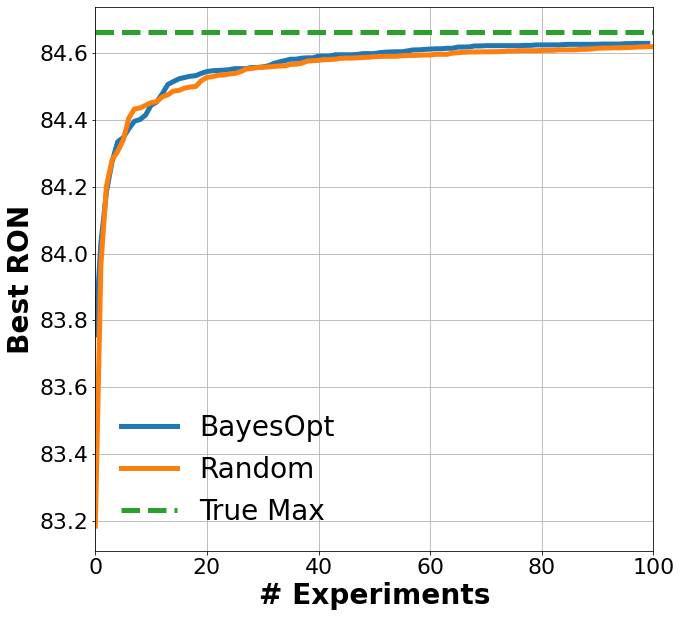

In [201]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(np.arange(avg_best_ron.shape[0]), avg_best_ron, linewidth=5, label='BayesOpt')
ax.plot(np.arange(ron.shape[0]), avg_best_ron_random, linewidth=5, label='Random')
ax.plot(np.arange(ron.shape[0]), np.ones_like(ron) * np.max(ron), linewidth=5, linestyle='--', label='True Max')
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
ax.set_xlabel('# Experiments', fontsize=28, fontweight='bold')
ax.set_ylabel('Best RON', fontsize=28, fontweight='bold')
ax.set_xlim([0, 100])
ax.grid(True)
ax.legend(fontsize=28, frameon=False)